# fMRI-03 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

Today's demonstration will be in two parts. In the first section, we will show you how to generate the predicted BOLD signal for analysis of a rapid event related design experiment. We will also show the sensitivity of these experiments to assumptions in the HRF. In the second section, we will discuss estimation efficiency and finite impulse response (FIR) designs.

## Part 1: Generating the predicted BOLD signal

In this first section, we will generate the predicted BOLD signal for a simple rapid event related (RER) experiment. In RER experiments, we have to consider two important design details: 
1. The order of trials
2. The order of null events

In this first example, we will provide for you a pre-optimized RER experiment design. In this experiment, we have two conditions. Each condition has 60 trials, and each trial lasts 1 second in duration. The total experiment length is 240 seconds. Let's make the design matrix for this experiment.

### [1] Define (super-sampled) times
Here we define the timing of the experiment. Importantly we first define the experiment in a "super-sampled" space, or we act like we have acquired far more data points than we actually have. We do this for several reasons. First, it functions to reduce the noisiness of our convolved regressors (more on that in a minute). Second, it allows us to model events that occur between TRs.

In [2]:
## Define experiment metadata.
n_times = 240
sfreq = 0.1

## Define (super-sampled) times.
sst = np.arange(0, n_times, sfreq)

### [2] Generate boxcars
Here we define a "boxcar" timeseries. In this step we make a binary timeseries (comprised of 0s and 1s), where 0s represent neuronal silence and 1s represent neuronal activity. 

It is difficult to optimize the event timings *a priori*, so we have generated an optimized rapid event design for you. We can load in the event timings and generate the neural boxcars.

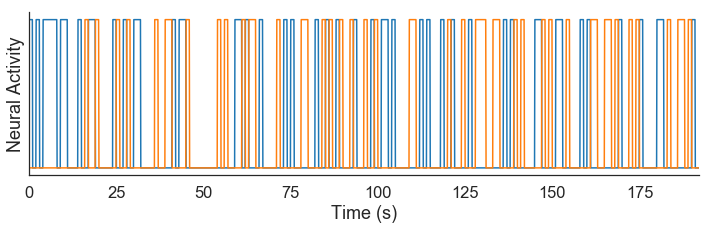

In [3]:
## Load experimental events.
npz = np.load('fmri-03-rer.npz')
events = npz['events']
events[:, -1] -= 1

## Generate boxcars.
boxcars = np.zeros((sst.size, 2))
for onset, offset, cond in events:
    boxcars[np.logical_and(sst >= onset, sst < offset), int(cond)] = 1
    
## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(sst, boxcars);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

### [3] Define the HRF
In this step, we define the expected shape of the HRF. Following convention, we will use the **SPM HRF**. 

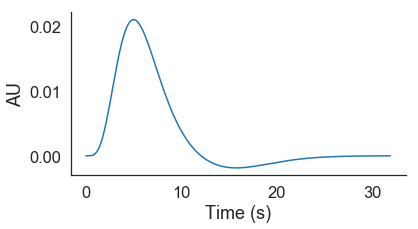

In [4]:
from fmritools.hrf import spm_hrf

## Define HRF.
hrf = spm_hrf(sfreq)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(sst[:hrf.size], hrf);
ax.set(xlabel='Time (s)', ylabel='AU')
sns.despine()

### [4] Convolution
Convolution describes a particular mathematical operation where we use two functions to produce a third function that expresses how the shape of one is modified by the other. In this case, we convolve the boxcars with the HRF to model how we expect the BOLD signal to change in response to the neural activity

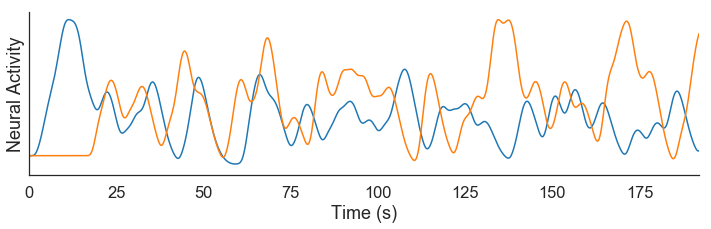

In [5]:
## Convolve boxcars + HRF.
bold = np.apply_along_axis(np.convolve, 0, boxcars, hrf)[:sst.size]

## Normalize regressor.
bold /= bold.max(axis=0)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(sst, bold);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

### [5] Downsampling
In this fifth and final step, we reduce the convolved timeseries to only those observations that we actually acquired.

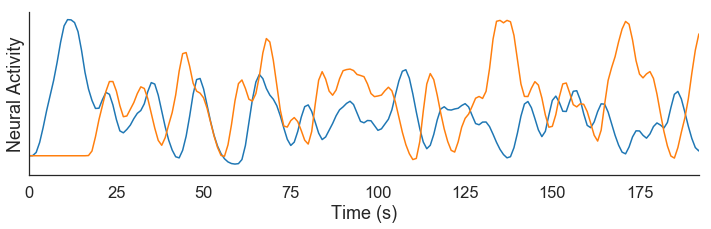

In [6]:
## Define observation times.
tr = 1
times = np.arange(n_times) * tr

## Define downsampling indices.
ix = np.in1d(sst, times)

## Downsampling.
boxcars = boxcars[ix]
bold = bold[ix]

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, bold);
ax.set(xlim=(0,192), xlabel='Time (s)', yticks=[], ylabel='Neural Activity')
sns.despine()

## Part 1.5: Simple Regression
Next, let's use the predicted BOLD timeseries we just made and use it perform simple linear regression.

### [1] Load and visualize data

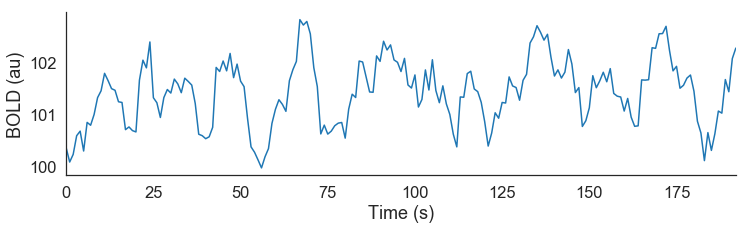

In [7]:
## Load and extract data.
y1 = npz['y1']

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y1);
ax.set(xlim=(0,192), xlabel='Time (s)', ylabel='BOLD (au)')
sns.despine()

### [2] Construct design matrix
The design matrix is collection of timeseries we will predicted the observed data here. Here we use the timeseries we made and an intercept, i.e. a column of 1s.

In [8]:
X = np.column_stack([np.ones(times.size), bold])

### [3] Regression

b1 = 1.522, b2 = 2.452


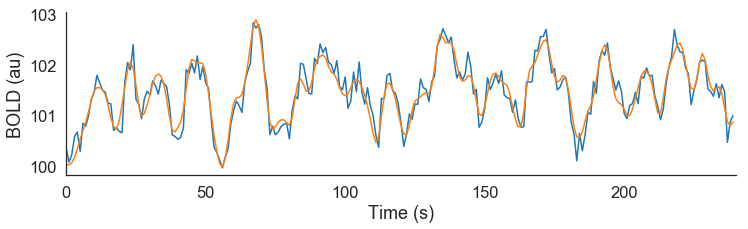

In [9]:
## Perform regression.
b, _, _, _ = np.linalg.lstsq(X, y1, rcond=-1)
print('b1 = %0.3f, b2 = %0.3f' %(b[1], b[2]))

## Posterior predictive check.
yhat = X @ b

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y1);
ax.plot(times, yhat);
ax.set(xlim=(0,y1.size), xlabel='Time (s)', ylabel='BOLD (au)')
sns.despine()

### [4] Sensitivity to HRF
One important difference between between block design experiments and rapid event designs is their relatively sensitivity to mis-modeling the HRF. For a block design, the repeated presentation of a stimulus means that minor inaccuracies in modeling the HRF do not matter much insofar that the summation of different HRF shapes will all yield the same asymptotic signal. The same is not true for rapid event designs.

Next we we will load in a second fMRI timeseries that has been generated from an fMRI model with identical amplitude but different HRF shape.

b1 = 1.247, b2 = 2.153


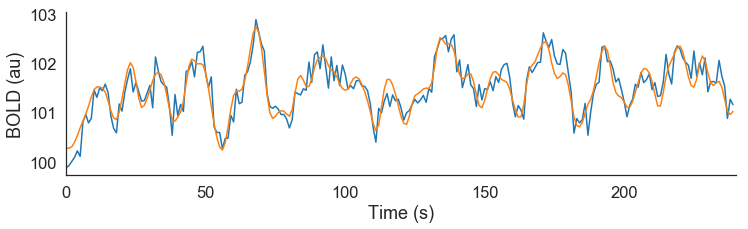

In [10]:
## Load and extract data.
y2 = npz['y2']

## Perform regression.
b, _, _, _ = np.linalg.lstsq(X, y2, rcond=-1)
print('b1 = %0.3f, b2 = %0.3f' %(b[1], b[2]))

## Posterior predictive check.
yhat = X @ b

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(times, y2);
ax.plot(times, yhat);
ax.set(xlim=(0,y2.size), xlabel='Time (s)', ylabel='BOLD (au)')
sns.despine()

## Part 2: Estimating the HRF

In experiments, we might want to actually estimate the shape of the HRF. Why?

1. As shown above, making assumptions might yield biased estimates of effects.
2. The HRF has actual meaning! Being able to estimate it actually tells us something about neural processing.

How do we do this? We use a finite impulse response (FIR) model. The logic is pretty straightforward. If we wanted to estimate the average HRF, we might cut out and align the HRF response starting from the onset of some event. An FIR design does the same thing, just through a design matrix. We create a binary matrix, where each column represents some window of HRF response for some condition.

### [1] Define FIR design matrix
The FIR design matrix is different than the design matrices we have discussed so far. Here we will create a binary matrix (containing only 0s and 1s). The matrix will have as many rows as observations, but each column will represent a different window of the HRF response. For example, if we have data at TR=1 and want to model 16s of the HRF response, we will have 16 columns per condition.

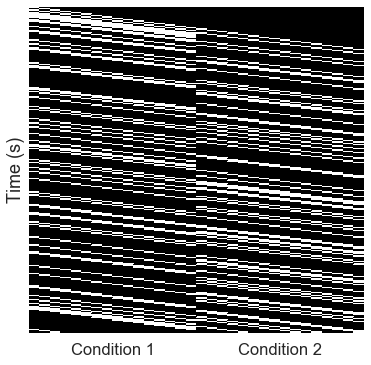

In [16]:
## Define metadata.
window = 16          # Number of time points to measure
k = 2                # Number of conditions
tr = 1               # Repetition time

## Preallocate space.
FIR = np.zeros((n_times, k, window))

## Iteratively construct design matrix.
for onset, _, cond in events:
    ## Find end of event. Events are `window` time units after `onset`,
    ## but can't last longer than the length of our data, `X.shape[0]`
    event_end = min(onset+window, X.shape[0])
    
    ## Define row indices.
    row_ix = np.arange(onset, event_end, dtype=int)
    
    ## Define col indices.
    col_ix = np.arange(0, row_ix.size, dtype=int)
    
    ## Update.
    FIR[row_ix, int(cond), col_ix] = 1
    
## Reshape to make this a design matrix, collapsing the non-time dimensions.
FIR = FIR.reshape((n_times, -1))
    
## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.heatmap(FIR, vmin=0, vmax=1, cmap='binary_r', cbar=False, ax=ax)
ax.set(xticks=[window/2., window*(1+1/2)], xticklabels=['Condition 1', 'Condition 2'], yticks=[], ylabel='Time (s)');

### [2] Estimate HRF Shape

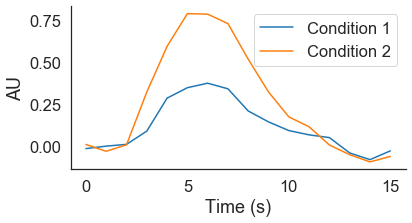

In [17]:
## Append intercept.
X = np.column_stack([np.ones(FIR.shape[0]), FIR])

## Regression.
b, _, _, _ = np.linalg.lstsq(X, y1, rcond=-1)
b = b[1:] # remove intercept

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(b[:window], label='Condition 1')
ax.plot(b[window:], label='Condition 2')
ax.set(xlabel='Time (s)', ylabel='AU')
sns.despine()
plt.legend()

## Part 3: Estimation Efficiency
In this next section we will discuss estimation efficiency, defined as the ability to accurately model the shape of the HRF itself. We demonstrate why jittering events is essential to increasing estimation efficiency and being able to resolve the HRF.

### [1] Load Data
To make the point more clear, we will load in the FIR design matrices for three experiments. These three experiments all share the same qualities: (1) they all involve presenting stimuli from two conditions 60 times each; (2) each stimulus (120 total) is presented for 1s; and (3) each experiment is 240s in total length, such that each experiment is comprised of 120s of stimulus presentation time and 120s of null time. 

These three experiments differ in the order of stimuli presentation. Experiment 1 will present stimuli in a blocked design. Experiment 2 will present stimuli of alternating conditions every 2s (1s pause between each stimulus). experiment 3 will present stimuli in an (optimally) randomized design, with variable stimulus condition order and variable jitter. The experiments and their corresponding FIR design matrices are presented below. (We assume TR=1 and M=16.) As can easily be observed, the FIR design matrices of the first two experiments have strong, repeating structure whereas the third exhibits greater variability.

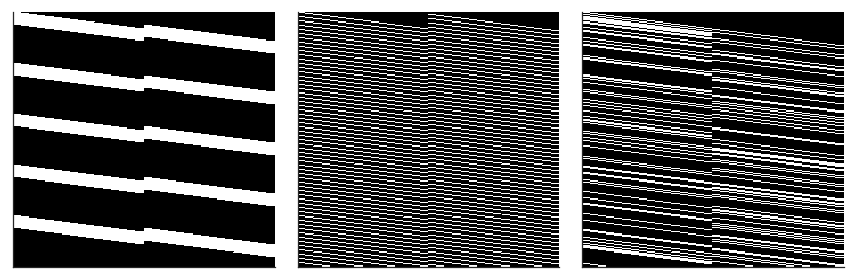

In [13]:
## Load experiment designs.
npz = np.load('fmri-03-efficiency.npz')
X1 = npz['X1']; X2 = npz['X2']; X3 = npz['X3']
times = npz['times']

## Plot designs.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)
for ax, X in zip(axes, [X1, X2, X3]): 
    sns.heatmap(X, vmin=0, vmax=1, cmap='binary_r', cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
sns.despine()
plt.tight_layout()

### Defining estimation efficiency

[Liu & Frank (2004)](https://www.sciencedirect.com/science/article/pii/S1053811903005779) provided a formal definition of detection power:

$$ C_{tot} = \frac{1}{ \frac{1}{N} \sum_{i \leq j} Tr[C_{ij}] } $$

Put another way, the estimation efficiency of our experimental design, $C_{tot}$, is the inverse of the average trace of the contrasts of interest, $C_{ij}$.

We define the estimation efficiency of a particular contrast as:

$$ C_{ij} = L_{ij} \left( X^T X \right)^{-1} L_{ij} $$

where $X^T X$ is the Fisher information matrix, and $L_{ij}$ is defined as:

$$ L_{ij} = D_{ij} \otimes I_k $$

where $D$ is a contrast vector as before and $\otimes$ is the Kronecker product.

Ignoring the math for a second, we can observe that estimation efficiency has a formula similar to detection power, except now we are evaluating the orthogonality of a sets of columns. This means that the estimation efficiency of an experiment bears a relationship to its information matrix, $X^TX$, similar to that observed for detection power.

Let's plot the the Fisher information matrix for each experiment is presented above. 

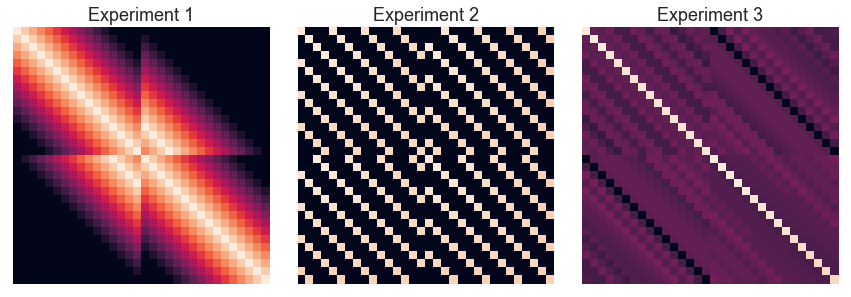

In [14]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
L = np.kron([1,-1], np.identity(16))

for i, (ax, X) in enumerate(zip(axes, [X1, X2, X3])):
    xx = X.T @ X
    xinv = np.linalg.pinv(xx)
    ax = sns.heatmap(X.T @ X, square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Experiment %s' %(i+1))
    
plt.tight_layout()

The diagonal elements reflect the number of observations for a given FIR window segment and condition (60 in all of the above). The off-diagonal elements reflect the covariance of two non-identical FIR window segments. As a result of the matrix inversion, experiments will be more efficient to the extent that their diagonals are large and their off-diagonals are small. 

Intuitively, this makes sense. In order to efficiently estimate a given FIR window, we would like it to be unconfounded by any other FIR window. If experiments have regular structure, then given FIR windows will always occur at the same point relative to one another, making it difficult to infer whether the BOLD signal at a given point reflects the contribution of the HRF response from the $i$th or $j$th window. Thus we can surmise that the block design and regular rapid event designs will have low estimation efficiency. 

Let's plot the design efficiency for each experiment.

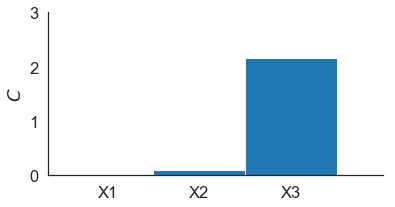

In [15]:
from fmritools.design import design_efficiency

## Initialize plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Iteratively compute and plot.
for i, X in enumerate([X1,X2,X3]):
    C = design_efficiency(X, k, window)
    ax.bar(i,C,1,color='#1f77b4')

## Add details to plot.
ax.set(xticks=range(4), xticklabels=['X1','X2','X3'], ylim=(0,3),ylabel=r'$C$')
sns.despine()

The first two experiments have very low efficiency as compared to the third. This highlights the importance of jittering for modeling the HRF fMRI experiments. The pseudo-random presentation of stimuli and null events reduces FIR window covariance resulting in more efficient estimation of the HRF.